In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import Counter
from copy import deepcopy
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE, VarianceThreshold, SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso

%matplotlib inline

In [2]:
!python --version

Python 3.6.1 :: Anaconda custom (64-bit)


### Reading data

In [3]:
separator = ','
all_data = pd.read_csv("all_data.csv", sep=separator)
morning_data = pd.read_csv("morning_data.csv", sep=separator)
afternoon_data =pd.read_csv("afternoon_data.csv", sep=separator)
datasets = [all_data, morning_data, afternoon_data]

In [4]:
all_data.columns

Index(['cid', 'patient_id', 'date1', 'age', 'gender', 'weight', 'height',
       'cardiostimulator', 'smoking', 'diseasediabetes', 'diseasehypertonia',
       'respiratory_disease', 'p_a', 'p_da', 'p_t', 'p_left_slopes',
       'p_right_slopes', 'q_a', 'q_b_t', 'q_e_t', 'r_a', 'r_left_slopes',
       'r_right_slopes', 'r_b_t', 'r_e_t', 's_a', 's_da', 's_b_t', 's_e_t',
       't_a', 't_da', 't_t', 't_left_slopes', 't_right_slopes', 'interval_pq',
       'komplex_qrs', 'segment_st', 'interval_qt', 'zubets_p', 'pulse', 'sdnn',
       'skewness', 'amo', 'swai', 'mo', 'drr', 'rrnn', 'pnn50', 'si', 'sati',
       'rmi', 'kurtosis', 'cv', 'rmssd', 'nn50', 'lf', 'lfhf', 'hfp', 'ulf',
       'tp', 'vlf', 'vlfp', 'lfp', 'br', 'ulfp', 'ic', 'hf', 'tpfull', 'lfw',
       'lfhfw', 'hfpw', 'ulfw', 'tpw', 'vlfw', 'vlfpw', 'lfpw', 'brw', 'ulfpw',
       'icw', 'hfw', 'tpfullw'],
      dtype='object')

In [5]:
def research_data(df, headers_color="", headers_bold=False):
    pretty_print(text_headers="First 5 strings of dataset", color=headers_color, bold=headers_bold)
    print(df.head())
    
    pretty_print(text_headers="Null values in data", color=headers_color, bold=headers_bold)
    print(np.sum(df.isnull()))

### Find columns with nan values

In [6]:
np.argwhere(np.sum(all_data.isnull()) != 0)

array([[15],
       [16],
       [21],
       [22],
       [23],
       [32],
       [33],
       [37],
       [38]], dtype=int64)

### Functions to fill nan values with closest

In [7]:
def appropriate_strings(df_without_none, string_with_nan, distance_metrics):
    most_appropriate_indexes = {}
    for distance_metric in distance_metrics:
        string_distances = distance_metric(string_with_nan.values.reshape(1, -1), df_without_none) 
        string_distances = string_distances.reshape(string_distances.shape[1],)
        min_distance_string_index = np.where(string_distances == min(string_distances))[0][0]
        most_appropriate_indexes.update({distance_metric.__name__: min_distance_string_index})
    counter = Counter(most_appropriate_indexes.values())
    return {"appropriate_indexes": most_appropriate_indexes, "best_index": counter.most_common(1)[0][0]}  

def replace_all_nan_by_values_from_closest_vector(df, distance_metrics):
    # creation of dataset without nan values
    df["index"] = df.index  # create column which will duplicate indexes to drop and restore rows with nan
    
    columns_with_nan = [column for column in df.columns if np.sum(df[column].isnull()) != 0]  # find columns with nan
    df_without_none = df.drop(df[columns_with_nan], axis=1)  # create dataset without columns with nan
        
    # finding list of all possible nan indexes and dict of column with nan and its indexes
    all_nan_indexes = set()
    for column_with_nan in columns_with_nan:
        nan_indexes = set(sum(np.argwhere(pd.isnull(df[column_with_nan])).tolist(), []))
        all_nan_indexes = all_nan_indexes.union(nan_indexes)
    all_nan_indexes = list(all_nan_indexes)  # list of indexes of strings with nan
    
    strings_with_nan = {}  # dict with strings with nan to restore them after finding the closest one
    for nan_index in all_nan_indexes:
        strings_with_nan.update({nan_index: df_without_none.loc[nan_index]})     
    df_without_none.drop(df_without_none.index[all_nan_indexes], inplace=True, axis=0)    
    df_without_none.reset_index(inplace=True, drop=True)  # reset indexes in a row

    # change nan values of original dataset
    for nan_index in all_nan_indexes:
        prepared_string = strings_with_nan[nan_index]  # take string with nan values to find the closest one
        best_string_index = appropriate_strings(df_without_none, prepared_string, distance_metrics)["best_index"]
        string_with_nan = df.loc[nan_index]  # string in which nan values will be found and replaced 
        real_best_index = int(df_without_none.loc[best_string_index]["index"])  # index from original dataset 
        closest_string = df.loc[real_best_index]  # the closest string from dataset without nan strings
        for column_with_nan in columns_with_nan:
            if pd.isnull(string_with_nan[column_with_nan]):
                df.loc[nan_index, column_with_nan] = closest_string[column_with_nan]  # set value
    df.drop(['index'], inplace=True, axis=1)

In [8]:
def dataset_preprocessing(df, distance_metrics=[euclidean_distances]):
    date_column = df.date1
    df.drop(["date1"], inplace=True, axis=1)
    replace_all_nan_by_values_from_closest_vector(df, distance_metrics)
    df["date1"] = date_column

### Dataset preprocessing

In [14]:
dataset_preprocessing(all_data)

In [22]:
print(all_data['p_left_slopes'].shape)
type(pd.isnull(all_data['p_left_slopes']))

(2093,)


pandas.core.series.Series

In [18]:
nan_indexes = set(sum(np.argwhere(pd.isnull(all_data['p_left_slopes'])).tolist(), []))

In [25]:
import sklearn
sklearn.__version__

'0.19.0'

In [27]:
import statsmodels
statsmodels.__version__

'0.8.0'

In [28]:
import scipy
scipy.__version__

'0.19.1'

In [9]:
np.argwhere(np.sum(all_data.isnull()) != 0)

array([], shape=(0, 1), dtype=int64)

As a result of the function all nan values were replaced by values from closest vectors of objects. Proof of this statement - previous cell, which calculate nan values in each column and returns an array of columns, which contain nans. As distance metrics were used euclidean and cosine distances

## Feature selection

In [10]:
df = deepcopy(all_data)
df.shape
X = df.drop(['respiratory_disease'], axis=1)   # Feature Matrix
y = df['respiratory_disease']
X.drop(["date1"], axis=1, inplace=True)

### Filtering

In [11]:
correlation = df.corr()
correlation_target = abs(correlation['respiratory_disease'])
# Selecting highly correlated features
relevant_features = correlation_target[correlation_target > 0.05]  
# all features have small correlation with target, so treshhold will be 0.05 to have appropriate amount of features
relevant_features_names = relevant_features.index

In [12]:
relevant_features

age                    0.132672
gender                 0.129185
weight                 0.052389
smoking                0.079051
diseasehypertonia      0.099160
respiratory_disease    1.000000
p_a                    0.113164
p_da                   0.063698
p_left_slopes          0.104293
p_right_slopes         0.061898
t_a                    0.097464
t_da                   0.061416
t_left_slopes          0.099196
t_right_slopes         0.115066
interval_pq            0.054545
swai                   0.075644
pnn50                  0.059350
rmi                    0.058107
kurtosis               0.053207
nn50                   0.062460
lfhf                   0.072832
hfp                    0.072332
lfp                    0.130819
br                     0.101001
lfhfw                  0.058687
hfpw                   0.066784
lfpw                   0.125096
brw                    0.091616
Name: respiratory_disease, dtype: float64

Now we should check their correlation between each other and drop features with high correlation

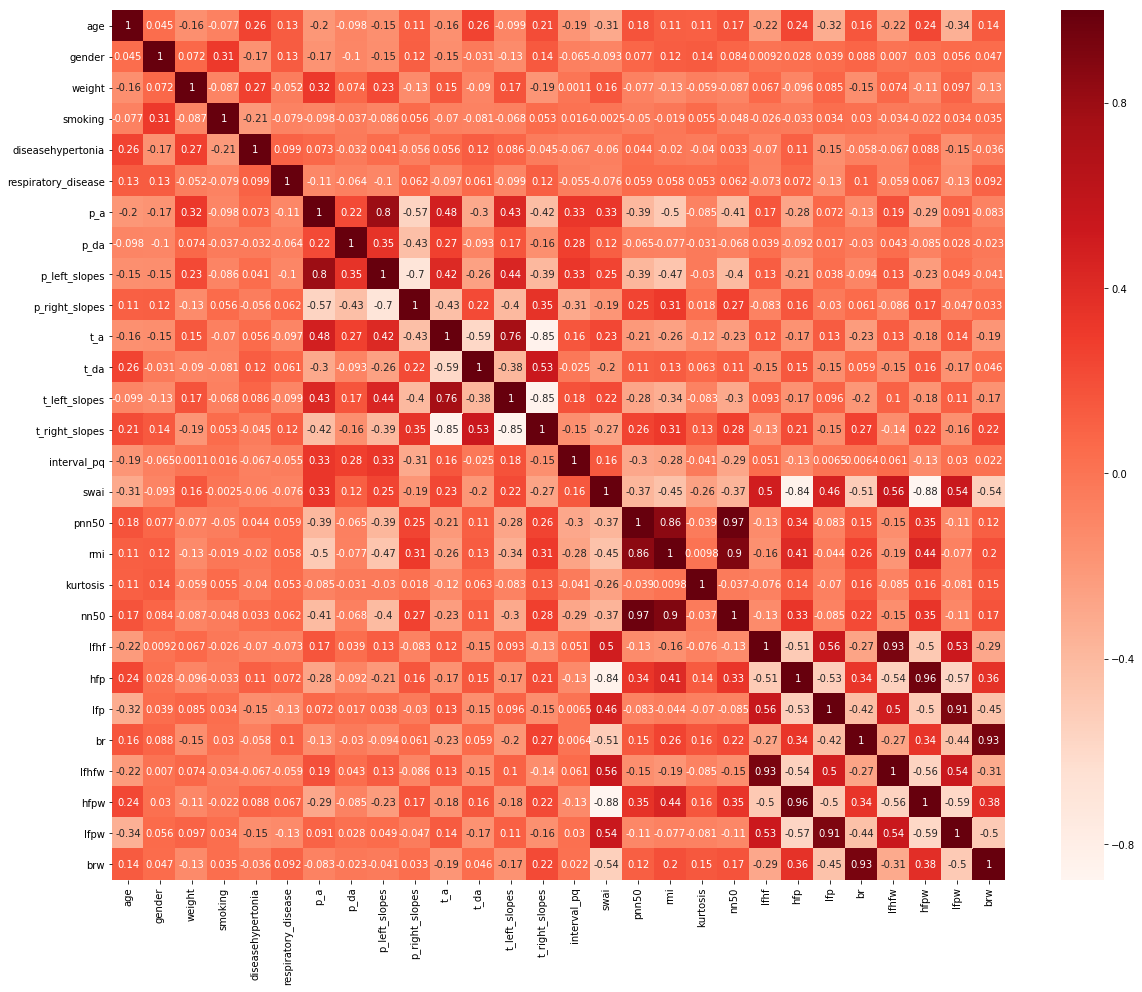

In [13]:
# Heatmap using Pearson correlation
plt.figure(figsize=(20, 16))
correlation = df[relevant_features_names].corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Reds)
plt.show()

In [14]:
corr_matrix = df[relevant_features_names].corr().abs()

#the matrix is symmetric so we need to extract upper triangle matrix without diagonal (k = 1)
corr_pairs=(corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool)).stack().sort_values(ascending=False))
extra_corr_pairs = corr_pairs[corr_pairs > 0.5]

In [15]:
for pair in extra_corr_pairs.index:
    feature_1, feature_2 = pair
    if feature_1 in relevant_features and feature_2 in relevant_features:
        feature_1_relevant_corr = relevant_features[feature_1]
        feature_2_relevant_corr = relevant_features[feature_2]
        if feature_1_relevant_corr > feature_2_relevant_corr:
            relevant_features.drop(feature_2, inplace=True)
        else:
            relevant_features.drop(feature_1, inplace=True)

In [16]:
relevant_features

age                    0.132672
gender                 0.129185
weight                 0.052389
smoking                0.079051
diseasehypertonia      0.099160
respiratory_disease    1.000000
p_a                    0.113164
p_da                   0.063698
t_right_slopes         0.115066
interval_pq            0.054545
kurtosis               0.053207
nn50                   0.062460
lfp                    0.130819
br                     0.101001
Name: respiratory_disease, dtype: float64

In [17]:
df_preprocessed = df[relevant_features.index]

In [18]:
df_preprocessed.to_csv("all_data_preprocessed_filtering.csv", sep=',', index=False)

### Backward Elimination

In [19]:
columns = list(X.columns)
pmax = 1
while (len(columns) > 0):
    p = []
    X_1 = X[columns]
    X_1 = sm.add_constant(X_1)
    model = sm.OLS(y, X_1).fit()
    p = pd.Series(model.pvalues.values[1:], index = columns)      
    pmax = max(p)
    feature_with_p_max = p.idxmax()
    if(pmax > 0.05):
        columns.remove(feature_with_p_max)
    else:
        break
selected_features_BE = columns
print(selected_features_BE)

['age', 'gender', 'weight', 'smoking', 'diseasehypertonia', 'p_a', 't_right_slopes', 'pnn50', 'rmi', 'cv', 'br', 'lfpw']


### RFE (Recursive Feature Elimination)

In [20]:
model = LogisticRegression()  # Initializing RFE model
rfe = RFE(model, 7)  # Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  # Fitting the data to model
model.fit(X_rfe,y)
print(rfe.support_)
print(rfe.ranking_)

[False False False  True False False False  True False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False  True False False False  True
  True False False False False False False False  True False False False
  True False False False False False False]
[72 65 35  1 30 63 73  1 10  2  9 67 15 59 61 38 40 41  7 68 69 21 11 27
 53  8  6  4 71 57 54 51  3 36 34 52 39 42 62 20 43 60 22 50 23 14 64 66
 18 16 12 13 29 48 25  1 17 33 47  1  1 19 70 24 46 32 58 26  1 31 45 55
  1  5 28 37 49 56 44]


In [21]:
nof_list=np.arange(1,13)            
high_score=0
# Variable to store the optimum features
nof=0           
score_list = []
for n in range(len(nof_list)):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.3, random_state = 0)
    model = LogisticRegression()
    rfe = RFE(model,nof_list[n])
    X_train_rfe = rfe.fit_transform(X_train,y_train)
    X_test_rfe = rfe.transform(X_test)
    model.fit(X_train_rfe,y_train)
    score = model.score(X_test_rfe,y_test)
    score_list.append(score)
    if(score>high_score):
        high_score = score
        nof = nof_list[n]
print("Optimum number of features: %d" %nof)
print("Score with %d features: %f" % (nof, high_score))

Optimum number of features: 9
Score with 9 features: 0.918790


In [22]:
cols = list(X.columns)
model = LogisticRegression()
#Initializing RFE model
rfe = RFE(model, 9)             
#Transforming data using RFE
X_rfe = rfe.fit_transform(X,y)  
#Fitting the data to model
model.fit(X_rfe,y)              
temp = pd.Series(rfe.support_,index = cols)
selected_features_rfe = temp[temp==True].index
print(selected_features_rfe)

Index(['gender', 'smoking', 'diseasehypertonia', 'interval_pq', 'hfp', 'vlfp',
       'lfp', 'hfpw', 'vlfpw'],
      dtype='object')
